# Modeling Shocks in COVID 19 with Stochastic Differential Equations

## Contents

- [Modeling Shocks in COVID 19 with Stochastic Differential Equations](#Modeling-Shocks-in-COVID-19-with-Stochastic-Differential-Equations)  
  - [Overview](#Overview)  
  - [The Basic SIR/SIRD Model](#The-Basic-SIR/SIRD-Model)  
  - [Introduction to SDEs](#Introduction-to-SDEs)  
  - [Ending Lockdown](#Ending-Lockdown)  
  - [Reinfection](#Reinfection)  

## Overview

Coauthored with Chris Rackauckas

This lecture continues the analyzing of the COVID-19 pandemic established in [this lecture](seir_model.html).

As before, the model is inspired by
*  Notes from [Andrew Atkeson](https://sites.google.com/site/andyatkeson/) and [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867)
* [Estimating and Forecasting Disease Scenarios for COVID-19 with an SIR Model](https://www.nber.org/papers/w27335) by Andrew Atkeson, Karen Kopecky and Tao Zha
* [Estimating and Simulating a SIRD Model of COVID-19 for Many Countries, States, and Cities](https://www.nber.org/papers/w27128) by Jesús Fernández-Villaverde and Charles I. Jones
* Further variations on the classic SIR model in Julia  [here](https://github.com/epirecipes/sir-julia).

Here we extend the model to include policy-relevant aggregate shocks.

### Continuous-Time Stochastic Processes

In continuous-time, there is an important distinction between randomness that leads to continuous paths vs. those which have ([almost surely right-continuous](https://en.wikipedia.org/wiki/C%C3%A0dl%C3%A0g)) jumps in their paths.  The most tractable of these includes the theory of [Levy Processes](https://en.wikipedia.org/wiki/L%C3%A9vy_process).

Among the appealing features of Levy Processes is that they fit well into the sorts of Markov modeling techniques that economists tend to use in discrete time, and usually fulfill the measurability required for calculating expected present discounted values.

Unlike in discrete-time, where a modeller has license to be creative, the rules of continuous-time stochastic processes are much stricter.  In practice, there are only two types of Levy Processes that can be used without careful measure theory.

1. [Weiner Processes](https://en.wikipedia.org/wiki/Wiener_process) (as known as Brownian Motion) which leads to a diffusion equations, and is the only continuous-time Levy process with continuous paths  
1. [Poisson Processes](https://en.wikipedia.org/wiki/Poisson_point_process) with an arrival rate of jumps in the variable.  


Every other Levy Process can be represented by these building blocks (e.g. a [Diffusion Process](https://en.wikipedia.org/wiki/Diffusion_process) such as Geometric Brownian Motion is a transformation of a Weiner process, a [jump diffusion](https://en.wikipedia.org/wiki/Jump_diffusion#In_economics_and_finance) is a diffusion process with a Poisson arrival of jumps, and a continuous-time markov chain (CMTC) is a Poisson process jumping between a finite number of states).

In this lecture, we will examine shocks driven by transformations of Brownian motion, as the prototypical Stochastic Differential Equation (SDE).

### Setup

In [1]:
using LinearAlgebra, Statistics, Random, SparseArrays

In addition, we will be exploring packages within the [SciML ecosystem](https://github.com/SciML/) and
others covered in previous lectures

In [2]:
using OrdinaryDiffEq, StochasticDiffEq
using Parameters, Plots

## The Basic SIR/SIRD Model

To demonstrate another common [compartmentalized model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Elaborations_on_the_basic_SIR_model) we will change the [previous SEIR](seir_model.html) model to remove the exposed state, and more carefully manage the death state, D.

The states are are now: susceptible (S), infected (I), resistant (R), or dead (D).

Comments:

- Unlike the previous SEIR model, the R state is only for those recovered, alive, and currently resistant.  
- As before, we start by assuming those have recovered have acquired immunity.  
- Later, we could consider transitions from R to S if resistance is not permanent due to virus mutation, etc.  

### Transition Rates

See the [previous lecture](seir_model.html), for a more detailed development of the model.

- $ \beta(t) $ is called the *transmission rate* or *effective contact rate* (the rate at which individuals bump into others and expose them to the virus)  
- $ \gamma $ is called the *resolution rate* (the rate at which infected people recover or die)  
- $ \delta(t) \in [0, 1] $ is the *death probability*  
- As before, we re-parameterize as $ R_0(t) := \beta(t) / \gamma $, where $ R_0 $ has previous interpretation  


Jumping directly to the equations in $ s, i, r, d $ already normalized by $ N $,


<a id='equation-sird'></a>
$$
\begin{aligned}
     d s  & = - \gamma \, R_0 \, s \,  i \, dt
     \\
      d i  & = \left(\gamma \, R_0 \, s \,  i  - \gamma  \, i \right) dt
     \\
     d r  & = (1-\delta) \gamma  \, i \, dt
     \\
     d d  & = \delta  \, \gamma  \, i \, dt
     \\
\end{aligned} \tag{1}
$$

Note that the notation has changed to heuristically put the $ dt $ on the right hand side, which will be used when adding the stochastic shocks.

## Introduction to SDEs

We start by extending our model to include randomness in $ R_0(t) $ and then the mortality rate $ \delta(t) $.

The result is a system of Stochastic Differential Equations (SDEs).

### Shocks to Transmission Rates

As before, we assume that the basic reproduction number, $ R_0(t) $, follows a process with a reversion to a value $ \bar{R}_0(t) $ which could conceivably be influenced by policy.  The intuition is that even if the targeted $ \bar{R}_0(t) $ was changed through social distancing/etc., lags in behavior and implementation would smooth out the transition, where $ \eta $ governs the speed of $ R_0(t) $ moves towards $ \bar{R}_0(t) $.

Beyond changes in policy, randomness in $ R_0(t) $ may come from shocks to the $ \beta(t) $ process.  For example,

- Misinformation on Facebook spreading non-uniformly.  
- Large political rallies, elections, or protests.  
- Deviations in the implementation and timing of lockdown policy between demographics, locations, or businesses within the system.  
- Aggregate shocks in opening/closing industries.  


To implement these sorts of randomness, we will add on a diffusion term with an instantaneous volatility of $ \sigma \sqrt{R_0} $.

- This equation is used in the [Cox-Ingersoll-Ross](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model) and [Heston](https://en.wikipedia.org/wiki/Heston_model) models of interest rates and stochastic volatility.  
- The scaling by the $ \sqrt{R_0} $ ensure that the process stays weakly positive.  The heuristic explanation is that the variance of the shocks converges to zero as R₀ goes to zero, enabling the upwards drift to dominate.  
- See [here](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model#Distribution) for a heuristic description of when the process is weakly and strictly positive.  


The notation for this [SDE](https://en.wikipedia.org/wiki/Stochastic_differential_equation#Use_in_probability_and_mathematical_finance) is then


<a id='equation-rsde'></a>
$$
\begin{aligned}
d R_{0t} &= \eta (\bar{R}_{0t} - R_{0t}) dt + \sigma \sqrt{R_{0t}} dW_t\\
\end{aligned} \tag{2}
$$

where $ W $ is standard Brownian motion (i.e a [Weiner Process](https://en.wikipedia.org/wiki/Wiener_process).

Heuristically, if $ \sigma = 0 $, divide this equation by $ dt $ and it nests the original ODE used in the previous lecture.

While we do not consider any calibration for the $ \sigma $ parameter, empirical studies such as [Estimating and Simulating a SIRD Model of COVID-19 for Many Countries, States, and Cities](https://www.nber.org/papers/w27128) (Figure 6) show highly volatile $ R_0(t) $ estimates over time.

Even after lockdowns are first implemented, we see variation between 0.5 and 1.5.  Since countries are made of interconnecting cities with such variable contact rates, a high $ \sigma $ seems reasonable both intuitively and empirically.

### Mortality Rates

Unlike the previous lecture, we will build up towards mortality rates which change over time.

Imperfect mixing of different demographic groups could lead to aggregate shocks in mortality (e.g. if a retirement home is afflicted vs. an elementary school).  These sorts of relatively small changes might be best modeled as a continuous path process.

Let $ \delta(t) $ be the mortality rate and in addition,

- Assume that the base mortality rate is $ \bar{\delta} $, which acts as the mean of the process, reverting at rate $ \theta $. In more elaborate models, this could be time-varying.  
- The diffusion term has a volatility $ \xi\sqrt{\delta (1 - \delta)} $.  
- As the process gets closer to either $ \delta = 1 $ or $ \delta = 0 $, the volatility goes to 0, which acts as a force to allow the mean reversion to keep the process within the bounds  
- Unlike the well-studied Cox-Ingersoll-Ross model, we make no claims on the long-run behavior of this process, but will be examining the behavior on a small timescale so this is not an issue.  


Given this, the stochastic process for the mortality rate is,


<a id='equation-dmt'></a>
$$
\begin{aligned}
d \delta_t & = \theta (\bar{\delta} - \delta_t) dt + \xi \sqrt{(\delta_t (1-\delta_t)} d W_t\\
\end{aligned} \tag{3}
$$

Where the $ W_t $ Brownian motion is independent from the previous process.

### System of SDEs

The system [(1)](#equation-sird) can be written in vector form $ x := [s, i, r, d, R₀, \delta] $ with parameter tuple parameter tuple $ p := (\gamma, \eta, \sigma, \theta, \xi, \bar{R}_0(\cdot), \bar{ \delta}) $

The general form of the SDE is.

$$
\begin{aligned}
d x_t &= F(x_t,t;p)dt + G(x_t,t;p) dW
\end{aligned}
$$

With the drift,


<a id='equation-dfcvsde'></a>
$$
F(x,t;p) := \begin{bmatrix}
    -\gamma \, R_0 \, s \,  i
    \\
    \gamma \, R_0 \,  s \,  i  - \gamma i
    \\
    (1-\delta) \gamma i
    \\
    \delta \gamma i
    \\
    \eta (\bar{R}_0(t) - R_0)
    \\
    \theta (\bar{\delta} - \delta)
    \\
\end{bmatrix} \tag{4}
$$

Here, it is convenient but not necessary for $ d W $ to have the same dimension as $ x $.  If so, then we can use a square matrix $ G(x,t;p) $ to associate the shocks with the appropriate $ x $ (e.g. diagonal noise, or using a covariance matrix).

As the two independent sources of Brownian motion only affect the $ d R_0 $ and $ d \delta $ terms (i.e. the 5th and 6th equations), define the covariance matrix as


<a id='equation-dg'></a>
$$
\begin{aligned}
G(x, t) &:= diag\left(\begin{bmatrix} 0 & 0 & 0 & 0 & \sigma \sqrt{R_0} & \xi \sqrt{\delta (1-\delta)} \end{bmatrix}\right)
\end{aligned} \tag{5}
$$

### Implementation

First, construct our $ F $ from [(4)](#equation-dfcvsde) and $ G $ from [(5)](#equation-dg)

In [3]:
function F(x, p, t)
    s, i, r, d, R₀, δ = x
    @unpack γ, R̄₀, η, σ, ξ, θ, δ_bar = p

    return [-γ*R₀*s*i;        # ds/dt
            γ*R₀*s*i - γ*i;   # di/dt
            (1-δ)*γ*i;        # dr/dt
            δ*γ*i;            # dd/dt
            η*(R̄₀(t, p) - R₀);# dR₀/dt
            θ*(δ_bar - δ);    # dδ/dt
            ]
end

function G(x, p, t)
    s, i, r, d, R₀, δ = x
    @unpack γ, R̄₀, η, σ, ξ, θ, δ_bar = p

    return [0; 0; 0; 0; σ*sqrt(R₀); ξ*sqrt(δ * (1-δ))]
end

G (generic function with 1 method)

Next create a settings generator, and then define a [SDEProblem](https://docs.sciml.ai/stable/tutorials/sde_example/#Example-2:-Systems-of-SDEs-with-Diagonal-Noise-1)  with Diagonal Noise.

In [4]:
p_gen = @with_kw (T = 550.0, γ = 1.0 / 18, η = 1.0 / 20,
                  R₀_n = 1.6, R̄₀ = (t, p) -> p.R₀_n, δ_bar = 0.01,
                  σ = 0.03, ξ = 0.004, θ = 0.2, N = 3.3E8)
p =  p_gen()  # use all defaults
i_0 = 25000 / p.N
r_0 = 0.0
d_0 = 0.0
s_0 = 1.0 - i_0 - r_0 - d_0
R̄₀_0 = 0.5  # starting in lockdown
δ_0 = p.δ_bar
x_0 = [s_0, i_0, r_0, d_0, R̄₀_0, δ_0]

prob = SDEProblem(F, G, x_0, (0, p.T), p)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9999242424242424, 7.575757575757576e-5, 0.0, 0.0, 0.5, 0.01]

We solve the problem with the [SOSRI](https://docs.sciml.ai/stable/solvers/sde_solve/#Full-List-of-Methods-1) algorithm (Adaptive strong order 1.5 methods for diagonal noise Ito and Stratonovich SDEs).

In [5]:
sol_1 = solve(prob, SOSRI());
@show length(sol_1.t);

length(sol_1.t) = 587


As in the deterministic case of the previous lecture, we are using an adaptive time-stepping method.  However, since this is an SDE, (1) you will tend to see more timesteps required due to the greater curvature; and (2) the number of timesteps will change with different shock realizations.

With stochastic differential equations, a “solution” is akin to a simulation for a particular realization of the noise process.

If we take two solutions and plot the number of infections, we will see differences over time:

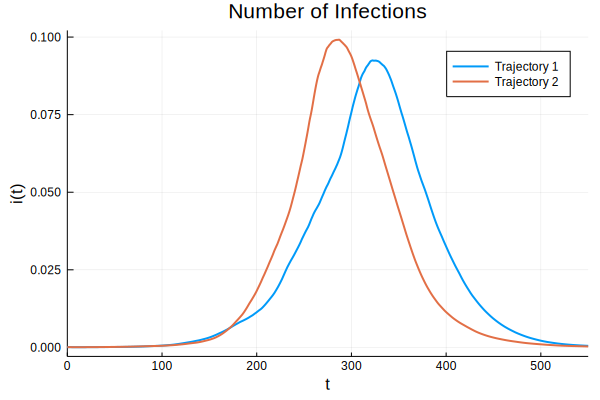

In [35]:
sol_2 = solve(prob, SOSRI())
plot(sol_1, vars=[2], title = "Number of Infections", label = "Trajectory 1",
     lw = 2, xlabel = "t", ylabel = "i(t)")
plot!(sol_2, vars=[2], label = "Trajectory 2", lw = 2, ylabel = "i(t)")

The same holds for other variables such as the cumulative deaths, mortality, and $ R_0 $:

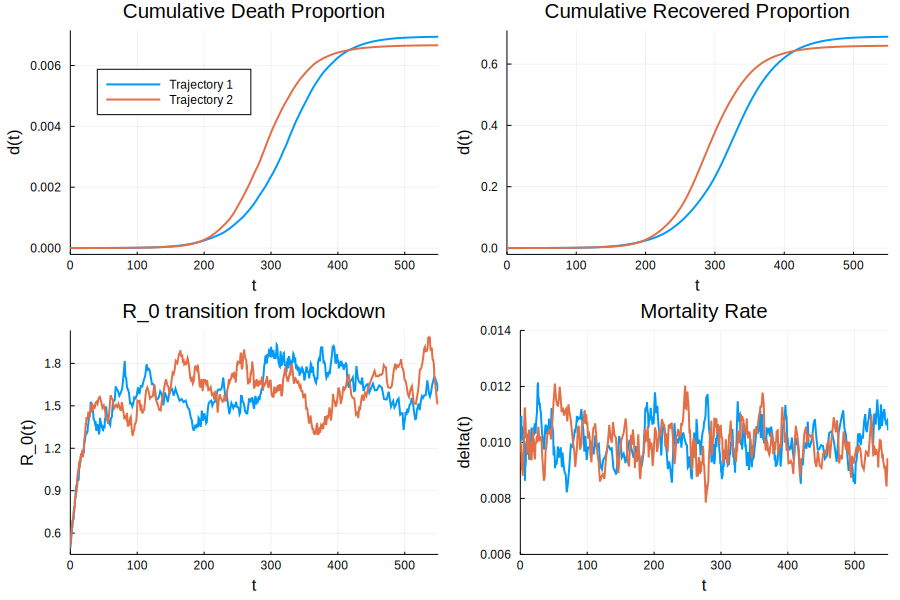

In [40]:
plot_1 = plot(sol_1, vars=[4], title = "Cumulative Death Proportion", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "d(t)", legend = :topleft)
plot!(plot_1, sol_2, vars=[4], label = "Trajectory 2", lw = 2)
plot_2 = plot(sol_1, vars=[3], title = "Cumulative Recovered Proportion", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "d(t)", legend = false)
plot!(plot_2, sol_2, vars=[3], label = "Trajectory 2", lw = 2)
plot_3 = plot(sol_1, vars=[5], title = "R_0 transition from lockdown", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "R_0(t)", legend=false)
plot!(plot_3, sol_2, vars=[5], label = "Trajectory 2", lw = 2)
plot_4 = plot(sol_1, vars=[6], title = "Mortality Rate", label = "Trajectory 1", legend=false,
              lw = 2, xlabel = "t", ylabel = "delta(t)", ylim = (0.006, 0.014))
plot!(plot_4, sol_2, vars=[6], label = "Trajectory 2", lw = 2)
plot(plot_1, plot_2, plot_3, plot_4, size = (900, 600))

See [here](https://diffeq.sciml.ai/stable/solvers/sde_solve/#Recommended-Methods-1) for comments on finding the appropriate SDE algorithm given the structure of $ F(x, t) $ and $ G(x, t) $

- If $ G $ has diagonal noise (i.e. $ G(x, t) $ is a diagonal, and possibly a function of the state), then `SOSRI` is the typical choice.  
- If $ G $ has additive and diagonal noise (i.e. $ G(t) $ is a diagonal and independent from the state), then `SOSRA` is usually the best algorithm for even mildly stiff $ F $.  
- If adaptivity is not required, then `EM` (i.e. Euler-Maruyama method typically used by economists) is flexible in its ability to handle different noise processes.  

### Ensembles

While individual simulations are useful, you often want to look at an ensemble of trajectories of the SDE in order to get an accurate picture of how the system evolves.

To do this, use the `EnsembleProblem` in order to have the solution compute multiple trajectories at once. The returned `EnsembleSolution` acts like an array of solutions but is imbued to plot recipes to showcase aggregate quantities.

For example:

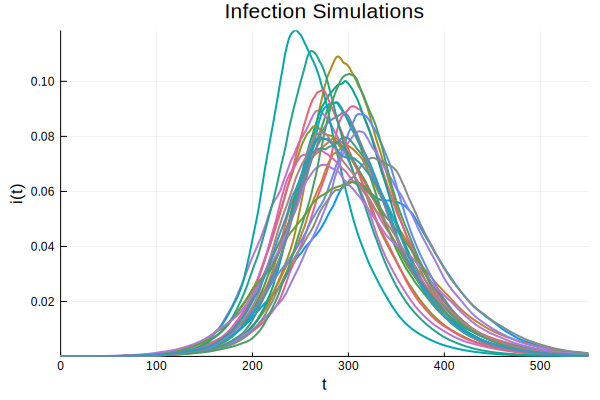

In [34]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, SOSRI(), EnsembleSerial(), trajectories = 25)
plot(sol, vars = [2], title = "Infection Simulations", ylabel = "i(t)", xlabel = "t", lw = 2)

Or, more frequently, you may want to run many trajectories and plot quantiles, which can be automatically run in [parallel](https://docs.sciml.ai/stable/features/ensemble/) using multiple threads, processes, or GPUs. Here we showcase `EnsembleSummary` which calculates summary information from an ensemble and plots the mean of the solution along with calculated quantiles of the simulation:

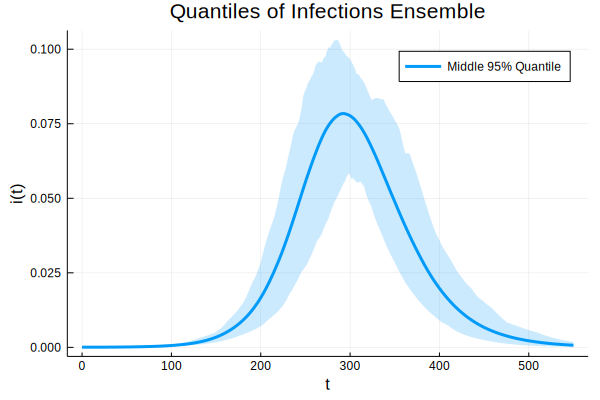

In [22]:
trajectories = 100  # choose larger for smoother quantiles
sol = solve(ensembleprob, SOSRI(), EnsembleThreads(), trajectories = trajectories)
summ = EnsembleSummary(sol) # defaults to saving 0.05, 0.95 quantiles
plot(summ, idxs = (2,), title = "Quantiles of Infections Ensemble", ylabel = "i(t)",
     xlabel = "t", labels = "Middle 95% Quantile", legend = :topright)

In addition, you can calculate more quantiles and stack graphs

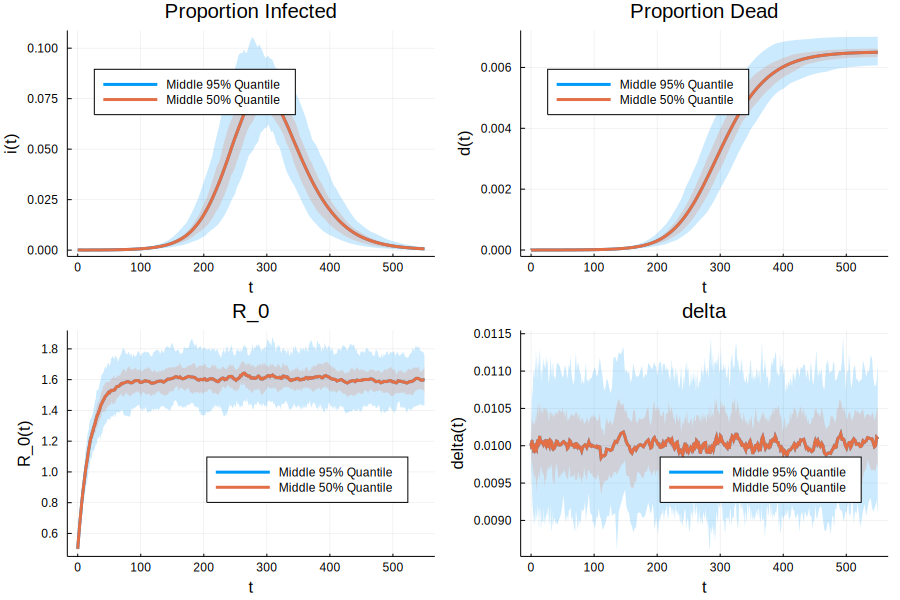

In [23]:
sol = solve(ensembleprob, SOSRI(), EnsembleThreads(), trajectories = trajectories)
summ = EnsembleSummary(sol) # defaults to saving 0.05, 0.95 quantiles
summ2 = EnsembleSummary(sol, quantiles = (0.25, 0.75))

plot(summ, idxs = (2,4,5,6),
    title = ["Proportion Infected" "Proportion Dead" "R_0" "delta"],
    ylabel = ["i(t)" "d(t)" "R_0(t)" "delta(t)"], xlabel = "t",
    legend = [:topleft :topleft :bottomright :bottomright],
    labels = "Middle 95% Quantile", layout = (2, 2), size = (900, 600))
plot!(summ2, idxs = (2,4,5,6),
    labels = "Middle 50% Quantile", legend =  [:topleft :topleft :bottomright :bottomright])

Some additional features of the ensemble and SDE infrastructure are

- [Plotting](https://diffeq.sciml.ai/stable/basics/plot/)  
- [Noise Processes](https://diffeq.sciml.ai/stable/features/noise_process/), [Non-diagonal noise](https://diffeq.sciml.ai/stable/tutorials/sde_example/#Example-4:-Systems-of-SDEs-with-Non-Diagonal-Noise-1), and [Correlated Noise](https://diffeq.sciml.ai/stable/tutorials/sde_example/#Example:-Spatially-Colored-Noise-in-the-Heston-Model-1)  
- [Parallel Ensemble features](https://diffeq.sciml.ai/stable/features/ensemble/)  
- Transforming the ensemble calculations with an [output_func or reduction](https://diffeq.sciml.ai/stable/features/ensemble/#Building-a-Problem-1)  
- Auto-GPU accelerated by using `EnsembleGPUArray()` from [DiffEqGPU](https://github.com/SciML/DiffEqGPU.jl/)  

### Changing Mitigation

Consider a policy maker who wants to consider the impact of relaxing lockdown at various speeds.

We will shut down the shocks to the mortality rate (i.e. $ \xi = 0 $) to focus on the variation caused by the volatility in $ R_0(t) $.

Consider $ \eta = 1/50 $ and $ \eta = 1/20 $, where we start at the same initial condition of $ R_0(0) = 0.5 $.

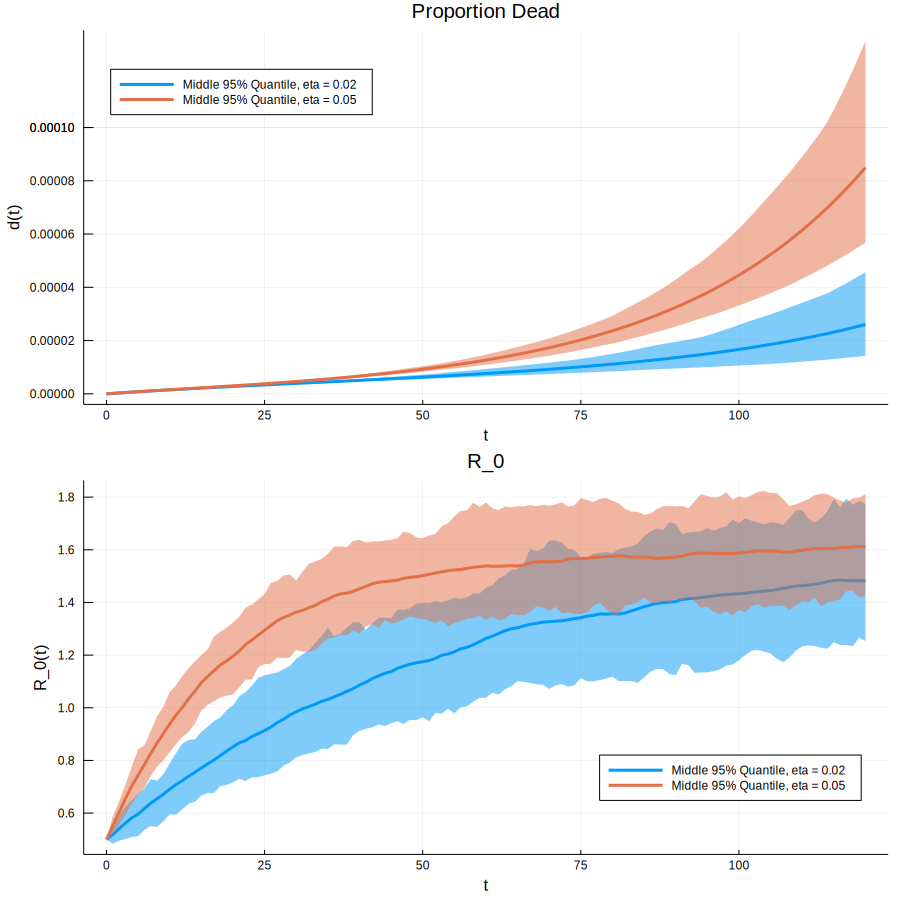

In [24]:
function generate_η_experiment(η; p_gen = p_gen, trajectories = 100,
                              saveat = 1.0, x_0 = x_0, T = 120.0)
    p = p_gen(η = η, ξ = 0.0)
    ensembleprob = EnsembleProblem(SDEProblem(F, G, x_0, (0, T), p))
    sol = solve(ensembleprob, SOSRI(), EnsembleThreads(),
                trajectories = trajectories, saveat = saveat)
    return EnsembleSummary(sol)
end

# Evaluate two different lockdown scenarios
η_1 = 1/50
η_2 = 1/20
summ_1 = generate_η_experiment(η_1)
summ_2 = generate_η_experiment(η_2)
plot(summ_1, idxs = (4,5),
    title = ["Proportion Dead" "R_0"],
    ylabel = ["d(t)" "R_0(t)"], xlabel = "t",
    legend = [:topleft :bottomright],
    labels = "Middle 95% Quantile, eta = $η_1",
    layout = (2, 1), size = (900, 900), fillalpha = 0.5)
plot!(summ_2, idxs = (4,5),
    legend = [:topleft :bottomright],
    labels = "Middle 95% Quantile, eta = $η_2", size = (900, 900), fillalpha = 0.5)

While the the mean of the $ d(t) $ increases, unsurprisingly, we see that the 95% quantile for later time periods is also much larger - even after the $ R_0 $ has converged.

That is, volatile contact rates (and hence $ R_0 $) can interact to make catastrophic worst-case scenarios due to the nonlinear dynamics of the system.

## Ending Lockdown

As in the deterministic lecture, we can consider two mitigation scenarios

1. choose $ \bar{R}_0(t) $ to target $ R_0 = 0.5 $ for 30 days and then $ R_0 = 2 $ for the remaining 17 months. This corresponds to lifting lockdown in 30 days.  
1. target $ R_0 = 0.5 $ for 120 days and then $ R_0 = 2 $ for the remaining 14 months. This corresponds to lifting lockdown in 4 months.  


Since empirical estimates of $ R_0(t) $ discussed in [[FVJ20]](../zreferences.html#nberw27128) and other papers show it to have wide variation, we will maintain a fairly larger $ \sigma $.

We start the model with 100,000 active infections.

In [25]:
R₀_L = 0.5  # lockdown
η_experiment = 1.0/10
σ_experiment = 0.04
R̄₀_lift_early(t, p) = t < 30.0 ? R₀_L : 2.0
R̄₀_lift_late(t, p) = t < 120.0 ? R₀_L : 2.0

p_early = p_gen(R̄₀ = R̄₀_lift_early, η = η_experiment, σ = σ_experiment)
p_late = p_gen(R̄₀ = R̄₀_lift_late, η = η_experiment, σ = σ_experiment)


# initial conditions
i_0 = 100000 / p_early.N
r_0 = 0.0
d_0 = 0.0
s_0 = 1.0 - i_0 - r_0 - d_0
δ_0 = p_early.δ_bar

x_0 = [s_0, i_0, r_0, d_0, R₀_L, δ_0]  # start in lockdown
prob_early = SDEProblem(F, G, x_0, (0, p_early.T), p_early)
prob_late = SDEProblem(F, G, x_0, (0, p_late.T), p_late)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9996969696969698, 0.00030303030303030303, 0.0, 0.0, 0.5, 0.01]

Simulating for a single realization of the shocks, we see the results are qualitatively similar to what we had before

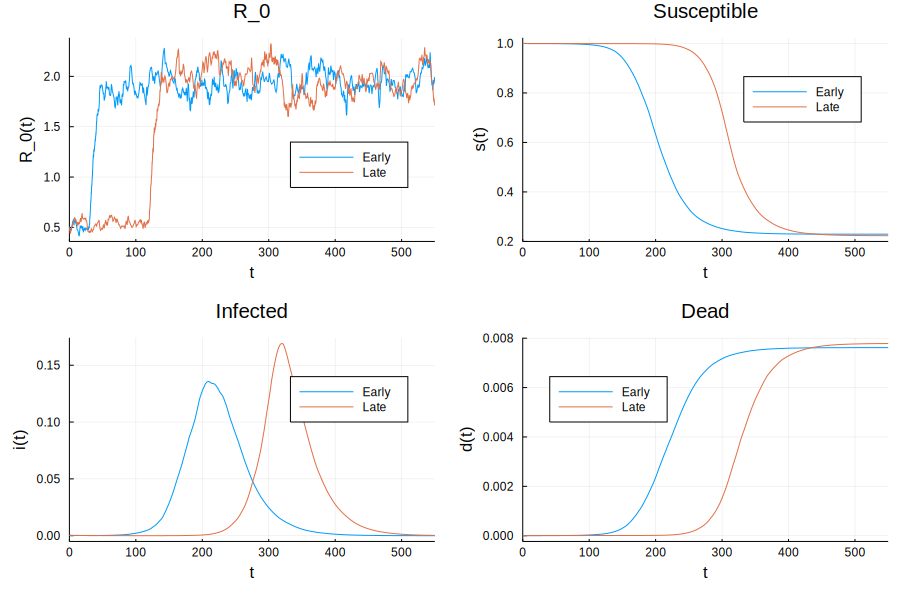

In [26]:
sol_early = solve(prob_early, SOSRI())
sol_late = solve(prob_late, SOSRI())
plot(sol_early, vars = [5, 1,2,4],
    title = ["R_0" "Susceptible" "Infected" "Dead"],
    layout = (2, 2), size = (900, 600),
    ylabel = ["R_0(t)" "s(t)" "i(t)" "d(t)"], xlabel = "t",
        legend = [:bottomright :topright :topright :topleft],
        label = ["Early" "Early" "Early" "Early"])
plot!(sol_late, vars = [5, 1,2,4],
        legend = [:bottomright :topright :topright :topleft],
        label = ["Late" "Late" "Late" "Late"])

However, note that this masks highly volatile values induced by the in $ R_0 $ variation, as seen in the ensemble

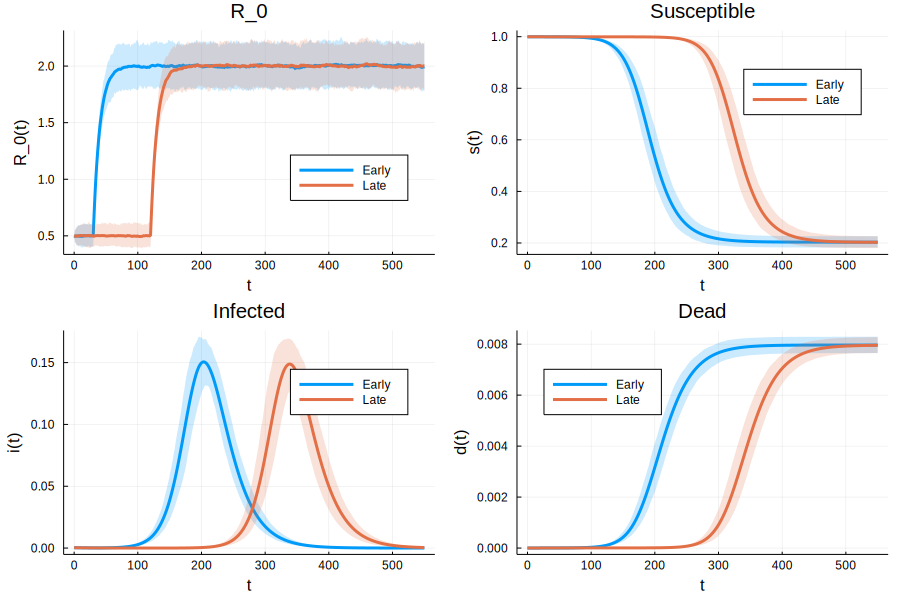

In [27]:
trajectories = 400
saveat = 1.0
ensemble_sol_early = solve(EnsembleProblem(prob_early), SOSRI(),
                           EnsembleThreads(), trajectories = trajectories, saveat = saveat)
ensemble_sol_late = solve(EnsembleProblem(prob_late), SOSRI(),
                          EnsembleThreads(), trajectories = trajectories, saveat = saveat)
summ_early = EnsembleSummary(ensemble_sol_early)
summ_late = EnsembleSummary(ensemble_sol_late)

plot(summ_early, idxs = (5, 1, 2, 4),
    title = ["R_0" "Susceptible" "Infected" "Dead"], layout = (2, 2), size = (900, 600),
    ylabel = ["R_0(t)" "s(t)" "i(t)" "d(t)"], xlabel = "t",
    legend = [:bottomright :topright :topright :topleft],
    label = ["Early" "Early" "Early" "Early"])
plot!(summ_late, idxs = (5, 1,2,4),
    legend = [:bottomright :topright :topright :topleft],
    label = ["Late" "Late" "Late" "Late"])

Finally, rather than looking at the ensemble summary, we can use data directly from the ensemble to do our own analysis.

For example, evaluating at an intermediate (`t = 350`) and final time step.

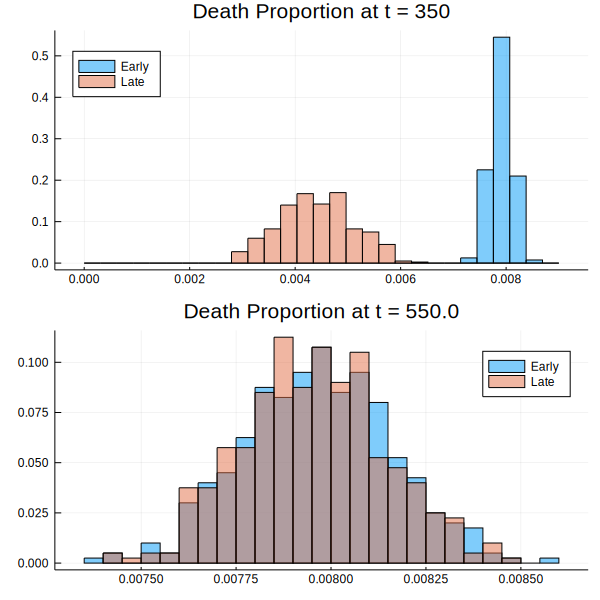

In [28]:
N = p_early.N
t_1 = 350
t_2 = p_early.T  # i.e. the last element
bins_1 = range(0.000, 0.009, length = 30)
bins_2 = 30  # number rather than grid.

hist_1 = histogram([ensemble_sol_early.u[i](t_1)[4] for i in 1:trajectories],
                   fillalpha = 0.5, normalize = :probability,
                   legend = :topleft, bins = bins_1,
                   label = "Early", title = "Death Proportion at t = $t_1")
histogram!(hist_1, [ensemble_sol_late.u[i](t_1)[4] for i in 1:trajectories],
           label = "Late", fillalpha = 0.5, normalize = :probability, bins = bins_1)
hist_2 = histogram([ensemble_sol_early.u[i][4, end] for i in 1:trajectories],
                   fillalpha = 0.5, normalize = :probability, bins = bins_2,
                   label = "Early", title = "Death Proportion at t = $t_2")
histogram!(hist_2, [ensemble_sol_late.u[i][4, end] for i in 1:trajectories],
           label = "Late", fillalpha = 0.5, normalize = :probability, bins = bins_2)
plot(hist_1, hist_2, size = (600,600), layout = (2, 1))

This shows that there are significant differences after a year, but by 550 days the graphs largely coincide.

In the above code given the return from `solve` on an `EnsembleProblem` , e.g. `ensemble_sol = solve(...)`

- You can access the i’th simulation as `ensemble_sol[i]`, which then has all of the standard [solution handling](https://diffeq.sciml.ai/stable/basics/solution/) features  
- You can evaluate at a real time period, `t`, with `ensemble_sol[i](t)`.  Or access the 4th element with `ensemble_sol[i](t)[4]`  
- If the `t` was not exactly one of the `saveat` values (if specified) or the adaptive timesteps (if it was not), then it will use interpolation  
- Alternatively, to access the results of the ODE as a grid exactly at the timesteps, where `j` is timestep index, use `ensemble_sol[i][j]` or the 4th element with `ensemble_sol[i][4, j]`  
- Warning: unless you have chosen a `saveat` grid, the timesteps will not be aligned between simulations.   That is, `ensemble_sol[i_1].t` wouldn’t match `ensemble_sol[i_2].t`.  In that case, use interpolation with `ensemble_sol[i_1](t)` etc.  

## Reinfection

As a final experiment, consider a model where the immunity is only temporary, and individuals become susceptible again.

In particular, assume that at rate $ \nu $ immunity is lost.  For illustration, we will examine the case if the average immunity lasts 12 months (i.e. $ 1/\nu = 360 $)

The transition modifies the differential equation [(1)](#equation-sird) to become


<a id='equation-sirdre'></a>
$$
\begin{aligned}
     d s  & = \left(- \gamma \, R_0 \, s \,  i + \nu \, r \right) dt
     \\
      d i  & = \left(\gamma \, R_0 \, s \,  i  - \gamma i \right) dt
     \\
     d r  & = \left((1-\delta) \gamma  i - \nu \, r\right) dt
     \\
     d d  & = \delta \gamma  i \, dt
     \\
\end{aligned} \tag{6}
$$

This change modifies the underlying `F` function and adds a parameter, but otherwise the model remains the same.

We will redo the “Ending Lockdown” simulation from above, where the only difference is the new transition.

In [29]:
function F_reinfect(x, p, t)
    s, i, r, d, R₀, δ = x
    @unpack γ, R̄₀, η, σ, ξ, θ, δ_bar, ν = p

    return [-γ*R₀*s*i + ν*r;  # ds/dt
            γ*R₀*s*i - γ*i;   # di/dt
            (1-δ)*γ*i - ν*r   # dr/dt
            δ*γ*i;            # dd/dt
            η*(R̄₀(t, p) - R₀);# dR₀/dt
            θ*(δ_bar - δ);    # dδ/dt
            ]
end

p_re_gen = @with_kw ( T = 550.0, γ = 1.0 / 18, η = 1.0 / 20,
                R₀_n = 1.6, R̄₀ = (t, p) -> p.R₀_n,
                δ_bar = 0.01, σ = 0.03, ξ = 0.004, θ = 0.2, N = 3.3E8, ν = 1/360)

p_re_early = p_re_gen(R̄₀ = R̄₀_lift_early, η = η_experiment, σ = σ_experiment)
p_re_late = p_re_gen(R̄₀ = R̄₀_lift_late, η = η_experiment, σ = σ_experiment)

trajectories = 400
saveat = 1.0
prob_re_early = SDEProblem(F_reinfect, G, x_0, (0, p_re_early.T), p_re_early)
prob_re_late = SDEProblem(F_reinfect, G, x_0, (0, p_re_late.T), p_re_late)
ensemble_sol_re_early = solve(EnsembleProblem(prob_re_early), SOSRI(), EnsembleThreads(),
                              trajectories = trajectories, saveat = saveat)
ensemble_sol_re_late = solve(EnsembleProblem(prob_re_late), SOSRI(), EnsembleThreads(),
                              trajectories = trajectories, saveat = saveat)
summ_re_early = EnsembleSummary(ensemble_sol_re_early)
summ_re_late = EnsembleSummary(ensemble_sol_re_late)

EnsembleSolution Solution of length 551 with uType:
Float64

The ensemble simulations for the $ \nu = 0 $ and $ \nu > 0 $ can be compared to see the impact in the absence of medical innovations.

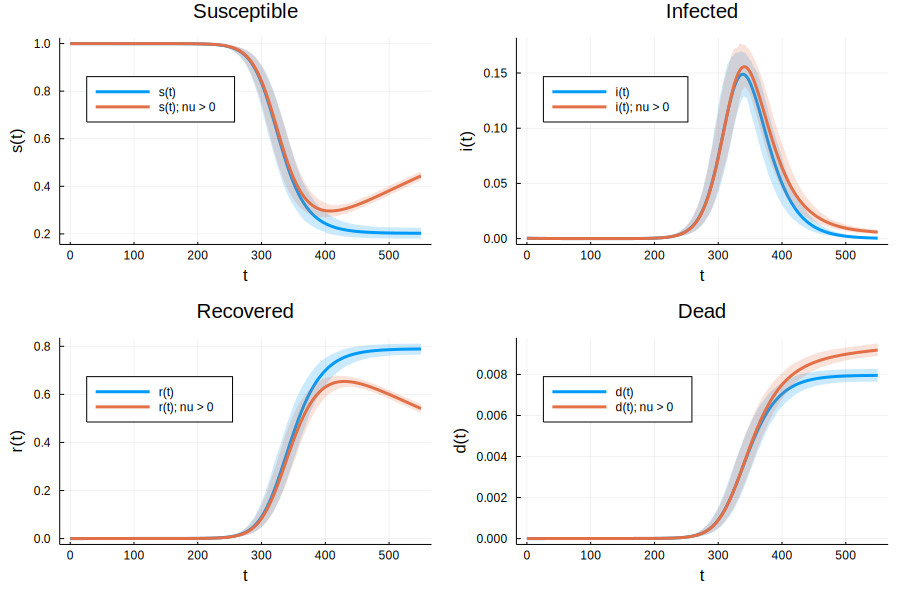

In [30]:
plot(summ_late, idxs = (1, 2, 3, 4),
    title = ["Susceptible" "Infected" "Recovered" "Dead"],
    layout = (2, 2), size = (900, 600),
    ylabel = ["s(t)" "i(t)" "r(t)" "d(t)"], xlabel = "t",
    legend = :topleft,
    label = ["s(t)" "i(t)" "r(t)" "d(t)"])
plot!(summ_re_late, idxs =  (1, 2, 3, 4),
    legend = :topleft,
    label = ["s(t); nu > 0" "i(t); nu > 0" "r(t); nu > 0" "d(t); nu > 0"])

Finally, we can examine the same early vs. late lockdown histogram

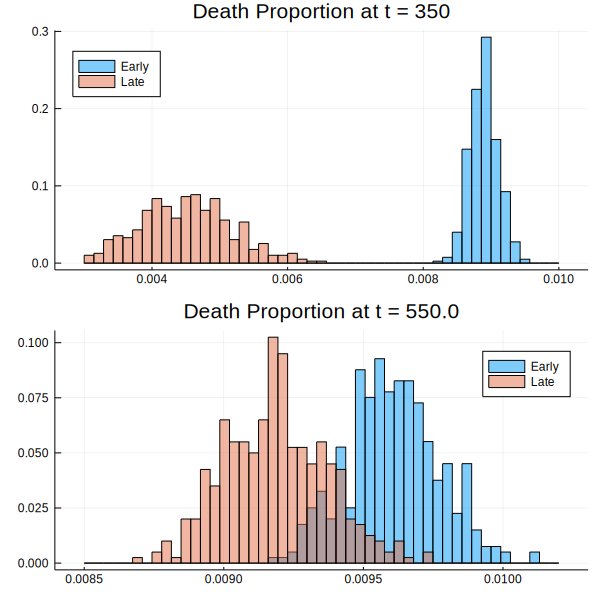

In [31]:
bins_re_1 = range(0.003, 0.010, length = 50)
bins_re_2 = range(0.0085, 0.0102, length = 50)
hist_re_1 = histogram([ensemble_sol_re_early.u[i](t_1)[4] for i in 1:trajectories],
                    fillalpha = 0.5, normalize = :probability,
                    legend = :topleft, bins = bins_re_1,
                    label = "Early", title = "Death Proportion at t = $t_1")
histogram!(hist_re_1, [ensemble_sol_re_late.u[i](t_1)[4] for i in 1:trajectories],
        label = "Late", fillalpha = 0.5, normalize = :probability, bins = bins_re_1)
hist_re_2 = histogram([ensemble_sol_re_early.u[i][4, end] for i in 1:trajectories],
                    fillalpha = 0.5, normalize = :probability, bins = bins_re_2,
                    label = "Early", title = "Death Proportion at t = $t_2")
histogram!(hist_re_2, [ensemble_sol_re_late.u[i][4, end] for i in 1:trajectories],
        label = "Late", fillalpha = 0.5, normalize = :probability,
        bins =  bins = bins_re_2)
plot(hist_re_1, hist_re_2, size = (600,600), layout = (2, 1))

In this case, there are significant differences between the early and late deaths and high variance.

This bleak simulation has assumed that no individuals has long-term immunity and that there will be no medical advancements on that time horizon - both of which are unlikely to be true.

Nevertheless, it suggest that the timing of lifting lockdown has a more profound impact after 18 months if we allow stochastic shocks imperfect immunity.